In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import roc_auc_score
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.feature_selection import mutual_info_regression
from datetime import datetime

%matplotlib inline
sns.set()

In [3]:
conn = sqlite3.connect('../Data/db/fraude_detection_warehouse_.db')

alert = pd.read_sql_query("SELECT * FROM alerts", conn)
customers = pd.read_sql_query("SELECT * FROM customers", conn)
devices = pd.read_sql_query("SELECT * FROM devices", conn)
transaction_history = pd.read_sql_query("SELECT * FROM transaction_history", conn)
transaction_patterns= pd.read_sql_query("SELECT * FROM transaction_patterns", conn)
transactions = pd.read_sql_query("SELECT * FROM transactions", conn)
transactions.head()

,transaction_id,customer_id,device_id,transaction_date,transaction_type,amount,status,is_fraud,location
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,2020-02-12,depôt,9.385805e+06,réussie,1,Douala
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,2022-02-03,depôt,3.358191e+06,réussie,0,Bafoussam
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,2019-11-09,depôt,7.307758e+06,réussie,1,Bafoussam
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,2018-07-18,transfert,3.127519e+06,réussie,1,Bafoussam
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,2019-12-29,retrait,4.435274e+06,réussie,0,Yaoundé


In [4]:
# Fusion des tables
df1 = transactions.merge(customers, on='customer_id', how='left').drop(columns=['first_name', 'last_name', 'transaction_date'])
df2 = df1.merge(devices, on='device_id', how='left')
df3 = df2.merge(transaction_history, on=['customer_id', 'transaction_id'], how='left')

df3.head()

,transaction_id,customer_id,device_id,transaction_type,amount,status,is_fraud,location,email,phone_number,...,region,device_type,os,manufacturer,model,last_used,history_id,previous_balance,new_balance,transaction_date
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,f66d0310-bf70-4552-a732-5950c93b1134,depôt,9.385805e+06,réussie,1,Douala,Kim.Nguyen@lopez-wolfe.com,+237 656344405,...,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1e9c3c0fc0b1496d8d2901d0f8f3531d,1.933918e+07,2.872498e+07,2020-02-12
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,f765ead3-ca24-48f4-9252-a6fd5fc53518,depôt,3.358191e+06,réussie,0,Bafoussam,Gregory.Webb@scott.com,+237 684119567,...,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,d9970217233245029374bceecdc315c0,9.557160e+06,1.291535e+07,2022-02-03
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,9cac18d3-defc-4142-9a39-b66fe1063f6e,depôt,7.307758e+06,réussie,1,Bafoussam,Mary.Frank@mcbride-oliver.biz,+237 682981090,...,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,76fcc12cfc944467b6465cd0aba2893c,1.430163e+07,2.160939e+07,2019-11-09
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,40ccde62-b98d-4e6b-bd3f-bf514cae73b9,transfert,3.127519e+06,réussie,1,Bafoussam,Mark.Nelson@yang.info,+237 681338859,...,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,3bb9c05095104929b845b85e2daa86e8,7.646344e+06,4.518825e+06,2018-07-18
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,16aa8a04-4cbd-48dc-88d2-ef9d0e8a2944,retrait,4.435274e+06,réussie,0,Yaoundé,Deborah.Stokes@faulkner-randall.net,+237 677098362,...,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,64f19595555c42c5ae3d1fb9eb17c793,9.679731e+06,5.244457e+06,2019-12-29


In [5]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   transaction_id     100000 non-null  object 
 1   customer_id        100000 non-null  object 
 2   device_id          100000 non-null  object 
 3   transaction_type   100000 non-null  object 
 4   amount             100000 non-null  float64
 5   status             100000 non-null  object 
 6   is_fraud           100000 non-null  int64  
 7   location           100000 non-null  object 
 8   email              100000 non-null  object 
 9   phone_number       100000 non-null  object 
 10  registration_date  100000 non-null  object 
 11  date_of_birth      100000 non-null  object 
 12  address            100000 non-null  object 
 13  city               100000 non-null  object 
 14  region             100000 non-null  object 
 15  device_type        100000 non-null  object 
 16  os 

In [6]:
date_columns = ["registration_date", "date_of_birth", "transaction_date", "last_used"]

for column in date_columns:
    df3[column] = pd.to_datetime(df3[column])

df3.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 24 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     100000 non-null  object        
 1   customer_id        100000 non-null  object        
 2   device_id          100000 non-null  object        
 3   transaction_type   100000 non-null  object        
 4   amount             100000 non-null  float64       
 5   status             100000 non-null  object        
 6   is_fraud           100000 non-null  int64         
 7   location           100000 non-null  object        
 8   email              100000 non-null  object        
 9   phone_number       100000 non-null  object        
 10  registration_date  100000 non-null  datetime64[ns]
 11  date_of_birth      100000 non-null  datetime64[ns]
 12  address            100000 non-null  object        
 13  city               100000 non-null  object   

In [7]:
data = df3.copy()
data.drop(columns=["transaction_id", "customer_id", "device_id", "email", "phone_number", "address", "history_id"], inplace=True)
data.head()

,transaction_type,amount,status,is_fraud,location,registration_date,date_of_birth,city,region,device_type,os,manufacturer,model,last_used,previous_balance,new_balance,transaction_date
0,depôt,9.385805e+06,réussie,1,Douala,2015-03-02,1981-01-07,Ayos,Centre,tablette,linux,LG,envy45,2023-12-01 16:08:02,1.933918e+07,2.872498e+07,2020-02-12
1,depôt,3.358191e+06,réussie,0,Bafoussam,2008-01-09,1986-12-05,Bafoussam,Ouest,tablette,ios,SONY,Bravia OLDE,2020-09-12 09:19:47,9.557160e+06,1.291535e+07,2022-02-03
2,depôt,7.307758e+06,réussie,1,Bafoussam,2015-06-06,1993-07-13,Bafoussam,Ouest,mobile,ios,SONY,Xperia 1 III,2020-10-05 12:26:19,1.430163e+07,2.160939e+07,2019-11-09
3,transfert,3.127519e+06,réussie,1,Bafoussam,2011-06-27,1977-03-30,Bafoussam,Ouest,tablette,ios,Apple,iphone 13,2020-05-29 13:34:21,7.646344e+06,4.518825e+06,2018-07-18
4,retrait,4.435274e+06,réussie,0,Yaoundé,2006-05-08,1950-09-29,Douala,Littoral,mobile,android,HP,envy 13,2021-04-30 12:36:51,9.679731e+06,5.244457e+06,2019-12-29


## Feature engineering

In [8]:
scaler = StandardScaler()
num_columns = list(data.select_dtypes(["float64"]).columns)
for col in num_columns:
    data[col] = scaler.fit_transform(data[[col]])

In [9]:
# Encodage des variables categorielles
le = LabelEncoder()
categorical_columns = data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    data[col] = le.fit_transform(data[col].astype(str))

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_type   100000 non-null  int32         
 1   amount             100000 non-null  float64       
 2   status             100000 non-null  int32         
 3   is_fraud           100000 non-null  int64         
 4   location           100000 non-null  int32         
 5   registration_date  100000 non-null  datetime64[ns]
 6   date_of_birth      100000 non-null  datetime64[ns]
 7   city               100000 non-null  int32         
 8   region             100000 non-null  int32         
 9   device_type        100000 non-null  int32         
 10  os                 100000 non-null  int32         
 11  manufacturer       100000 non-null  int32         
 12  model              100000 non-null  int32         
 13  last_used          100000 non-null  datetime6

In [11]:
# Fonction pour extraire les composantes de date
def extract_date_features(data, column):
    data[f'{column}_day'] = data[column].dt.day
    data[f'{column}_month'] = data[column].dt.month
    data[f'{column}_year'] = data[column].dt.year
    data[f'{column}_weekday'] = data[column].dt.weekday
    data[f'{column}_quarter'] = data[column].dt.quarter
    return data

# Conversion des dates et extraction des caractéristiques
date_columns = ['transaction_date','last_used', 'registration_date'] # 'date_of_birth'
for col in date_columns:
    data = extract_date_features(data, col)
    
    # Suppression de la colonne de date originale
    data = data.drop(columns=[col])

In [12]:
print(data.columns)

Index(['transaction_type', 'amount', 'status', 'is_fraud', 'location',
       'date_of_birth', 'city', 'region', 'device_type', 'os', 'manufacturer',
       'model', 'previous_balance', 'new_balance', 'transaction_date_day',
       'transaction_date_month', 'transaction_date_year',
       'transaction_date_weekday', 'transaction_date_quarter', 'last_used_day',
       'last_used_month', 'last_used_year', 'last_used_weekday',
       'last_used_quarter', 'registration_date_day', 'registration_date_month',
       'registration_date_year', 'registration_date_weekday',
       'registration_date_quarter'],
      dtype='object')


In [13]:
# Sélectionner uniquement les colonnes de date nouvellement créées
date_columns = [col for col in data.columns if any(x in col for x in ['_day', '_month', '_year', '_weekday', '_quarter'])]

# Afficher les premières lignes de ces colonnes
print(data[date_columns].head(10))

   transaction_date_day  transaction_date_month  transaction_date_year  \
0                    12                       2                   2020   
1                     3                       2                   2022   
2                     9                      11                   2019   
3                    18                       7                   2018   
4                    29                      12                   2019   
5                     4                       1                   2022   
6                     3                       9                   2019   
7                     3                      12                   2023   
8                     2                       2                   2019   
9                     4                       8                   2022   

   transaction_date_weekday  transaction_date_quarter  last_used_day  \
0                         2                         1              1   
1                         3              

In [14]:
date_of_today = datetime.now()

def calculate_and_assign(row):
  years_since_birth = int((date_of_today - row['date_of_birth']).days / 360)
  return pd.Series({'year_since_birth': years_since_birth})

data["year_since_birth"] = data.apply(calculate_and_assign, axis=1)
data.drop(columns=["date_of_birth"], inplace=True)
data.head()

,transaction_type,amount,status,is_fraud,location,city,region,device_type,os,manufacturer,...,last_used_month,last_used_year,last_used_weekday,last_used_quarter,registration_date_day,registration_date_month,registration_date_year,registration_date_weekday,registration_date_quarter,year_since_birth
0,0,1.080667,0,1,31,6,4,1,2,2,...,12,2023,4,4,2,3,2015,0,1,44
1,0,-0.634216,0,0,11,11,16,1,1,3,...,9,2020,5,3,9,1,2008,2,1,38
2,0,0.489454,0,1,11,11,16,0,1,3,...,10,2020,0,4,6,6,2015,5,2,31
3,2,-0.699843,0,1,11,11,16,1,1,0,...,5,2020,4,2,27,6,2011,0,2,48
4,1,-0.327781,0,0,98,31,12,0,0,1,...,4,2021,4,2,8,5,2006,0,2,74


In [15]:
lignes_avec_manquantes = df3[df3.isnull().any(axis=1)]

nombre_lignes_manquantes = lignes_avec_manquantes.shape[0]

print("Nombre de lignes avec des valeurs manquantes :", nombre_lignes_manquantes)

Nombre de lignes avec des valeurs manquantes : 0


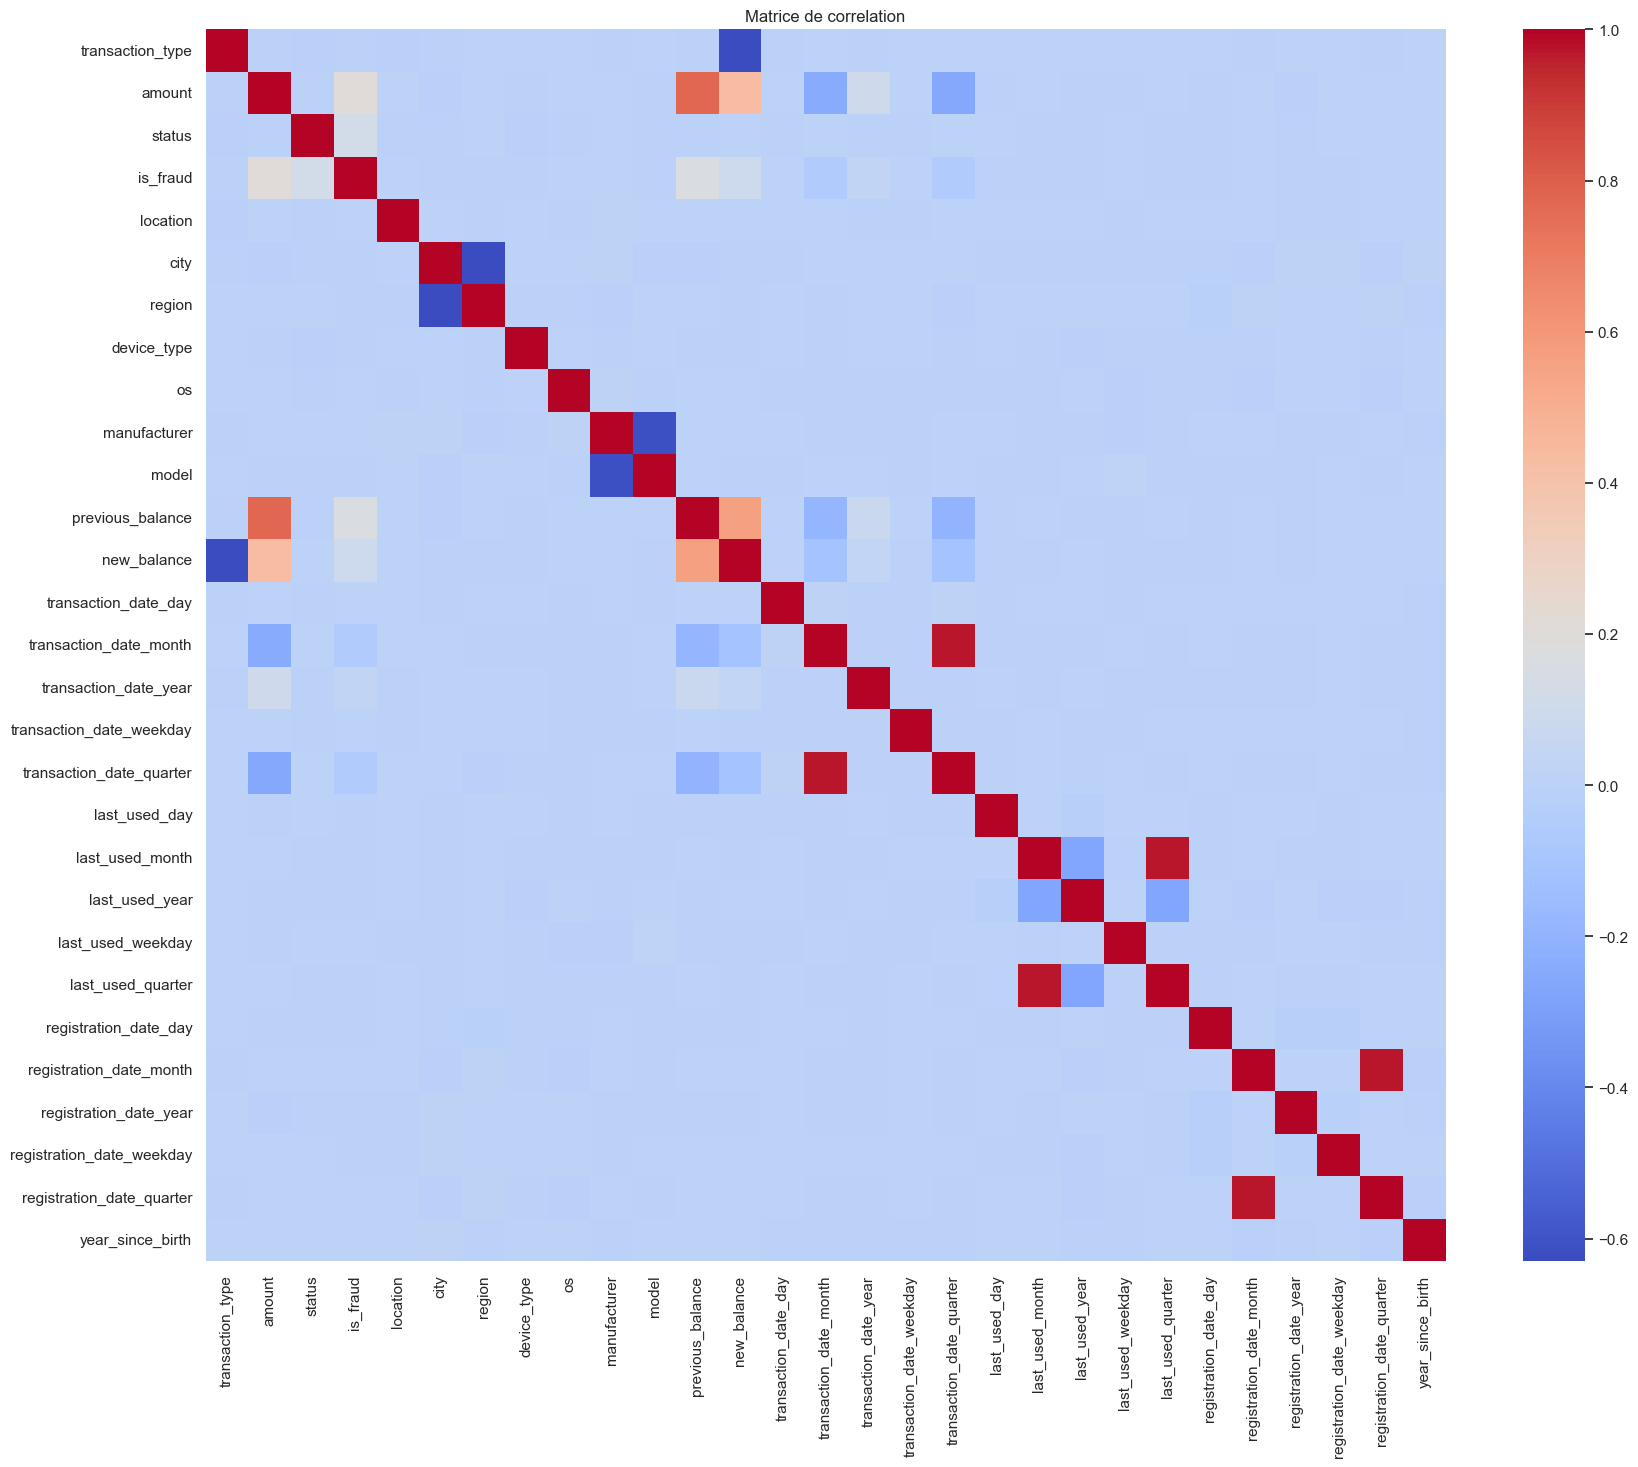

In [16]:
# Analyse de correlation
corr_matrix = data.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Matrice de correlation')
plt.show()

In [17]:
# Selection des variables les plus correlees avec is_fraud
correlations_with_fraud = corr_matrix['is_fraud'].abs().sort_values(ascending=False)
print("Top 10 variables les plus corrélées avec is_fraud:")
print(correlations_with_fraud.head(6))

Top 10 variables les plus corrélées avec is_fraud:
is_fraud                    1.000000
amount                      0.209955
previous_balance            0.162420
status                      0.115933
new_balance                 0.092639
transaction_date_quarter    0.056190
Name: is_fraud, dtype: float64


nous utiliserons les régions comme localisation par la suite

In [18]:
# Information mutuelle
X = data.drop(columns=['is_fraud']) #Contient les variables explicatives (indépendantes)
y = data['is_fraud'] #Contient la variable cible (dépendante)
mi_scores = mutual_info_regression(X, y)
mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)
print("\nTop 10 variables selon l'information mutuelle:")
print(mi_scores.head(5))


Top 10 variables selon l'information mutuelle:
amount                      0.031331
previous_balance            0.013814
new_balance                 0.008820
transaction_date_quarter    0.007488
status                      0.006636
Name: MI Scores, dtype: float64


In [91]:
# Sélection finale des variables importantes
important_features = list(set(list(correlations_with_fraud.head(20).sort_values(ascending=False).index) + list(mi_scores.head(20).sort_values(ascending=False).index)))
important_features = [f for f in important_features if f != 'is_fraud']
print("\nVariables importantes sélectionnées:")
print(len(important_features))


Variables importantes sélectionnées:
26


fusionner les dataframes

In [92]:
# Creation du dataset final
X_final = data[important_features]
y_final = data['is_fraud']

In [93]:
# Entrainement du modele avec Isolation Forest
model = IsolationForest(contamination=0.5, random_state=42)
y_pred = model.fit_predict(X_final)
y_pred

array([-1,  1,  1, ..., -1,  1,  1])

In [94]:
# evaluons la precision du modele
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Convertir les prédictions de l'Isolation Forest (-1 pour anomalie, 1 pour normal) 
# en format binaire (1 pour anomalie, 0 pour normal)
#y_pred_binary = [1 if pred == -1 else 0 for pred in y_pred]

y_pred_binary = np.where(y_pred==-1, 0, y_pred)

# Calculer et afficher les métriques de classification
print(classification_report(y_final, y_pred_binary))

# Calculer l'AUC-ROC
auc_roc = roc_auc_score(y_final, y_pred_binary)
print(f"AUC-ROC: {auc_roc}")

              precision    recall  f1-score   support

           0       0.40      0.46      0.43     43293
           1       0.53      0.47      0.50     56707

    accuracy                           0.46    100000
   macro avg       0.46      0.46      0.46    100000
weighted avg       0.47      0.46      0.47    100000

AUC-ROC: 0.46426703752467496


In [36]:
print(y_pred_binary[:20])
print(y_pred[:20])

[0 1 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 0]
[-1  1 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1 -1 -1 -1  1 -1 -1]


In [37]:
# Afficher la matrice de confusion
print("Matrice de confusion:")
print(confusion_matrix(y_final, y_pred_binary))

Matrice de confusion:
[[19817 23476]
 [30183 26524]]


In [38]:
# Affichage des résultats
print("\nNombre d'anomalies détectées:", sum(y_pred == -1))


Nombre d'anomalies détectées: 50000


In [46]:
X_final

,os,model,last_used_weekday,device_type,last_used_year,last_used_month,location,amount,new_balance,transaction_date_quarter,...,registration_date_weekday,transaction_date_year,registration_date_quarter,previous_balance,region,registration_date_day,transaction_type,registration_date_month,manufacturer,transaction_date_month
0,2,16,4,1,2023,12,31,1.080667,2.265914,1,...,0,2020,1,1.923607,4,2,0,3,2,2
1,1,3,5,1,2020,9,11,-0.634216,0.292457,1,...,2,2022,1,-0.223154,16,9,0,1,3,2
2,1,12,0,0,2020,10,11,0.489454,1.377701,4,...,5,2019,2,0.818068,16,6,0,6,3,11
3,1,18,4,1,2020,5,11,-0.699843,-0.755651,3,...,0,2018,2,-0.642502,16,27,2,6,0,7
4,0,15,4,0,2021,4,98,-0.327781,-0.665073,4,...,0,2019,2,-0.196255,12,8,1,5,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,2,18,1,0,2022,5,18,-1.070791,-0.375315,4,...,6,2020,2,-1.060415,13,8,0,4,0,10
99996,0,4,0,1,2023,12,94,-0.342021,-0.999272,1,...,3,2022,4,-0.794801,12,8,2,12,2,3
99997,3,13,4,1,2021,11,27,-0.116105,-0.113921,4,...,6,2022,1,0.936019,4,17,2,2,3,10
99998,3,21,2,0,2023,3,32,0.691473,-1.165859,3,...,4,2022,4,-0.290470,16,14,2,12,1,7


**Feature selection**

In [97]:
test = SelectKBest(score_func=chi2)
fit = test.fit(data.drop(columns="is_fraud").abs(), list(y_final))

In [100]:
np.set_printoptions(precision=3)
features = fit.transform(data.drop(columns="is_fraud"))
print(features[0:5, :])
feat = pd.DataFrame()
feat["num_features"] = data.drop(columns="is_fraud").columns
feat["score"] = fit.scores_
feat.sort_values(by="score", ascending=False, inplace=True)
feat = feat.reset_index().drop(columns=["index"])
feat

[[ 1.081  0.    31.     6.    16.     1.924  2.266  2.     1.     1.   ]
 [-0.634  0.    11.    11.     3.    -0.223  0.292  2.     1.    12.   ]
 [ 0.489  0.    11.    11.    12.     0.818  1.378 11.     4.     5.   ]
 [-0.7    0.    11.    11.    18.    -0.643 -0.756  7.     3.    29.   ]
 [-0.328  0.    98.    31.    15.    -0.196 -0.665 12.     4.    30.   ]]


,num_features,score
0,status,1209.266449
1,new_balance,610.855064
2,transaction_date_month,557.199012
3,amount,375.784373
4,transaction_date_quarter,156.894611
5,previous_balance,81.234919
6,city,56.512169
7,location,50.726259
8,last_used_day,11.163415
9,model,8.201490


In [101]:

def model_fit_transform(features):
    X  = data[features]
    model_1 = IsolationForest(contamination=0.5, random_state=42)
    model_1.fit(X)

    pred_1= model_1.predict(X)
    pred_1 = np.where(pred_1==-1, 0, pred_1)
    print(f"{pred_1[:10]}\n\n")

    #evaluation
    print(roc_auc_score(y_final, pred_1))

In [103]:
feature_imp = list(feat.head(29).num_features)
print(len(important_features))
print(len(feature_imp))

26
28


In [104]:
model_fit_transform(important_features)

[0 1 1 1 0 0 1 0 1 1]


0.46426703752467496


In [105]:
model_fit_transform(feature_imp)

[0 1 0 1 0 0 1 0 1 1]


0.46447070217258224


In [95]:
len(list(data.columns))

29

## Classification des customers par cluster

In [ ]:
customers.head()

,customer_id,region,email,phone_number,year_since_registration,year_since_birth
0,3690ac9fb2724cd0921a9e196a128fe1,North-West,Joseph.Alvarado@ortega.com,+237 655777212,8,53
1,e25e1f2edc234162bcb914a95397f259,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240,8,65
2,42c5133da168479a8ceb49d7ec6454f7,Littoral,Blake.Wheeler@jenkins.com,+237 653049060,7,60
3,9b32b433b97e494f8150b1b6aa3d6c46,Ouest,Melanie.Sharp@osborn.net,+237 676356820,18,41
4,2e9003baf3b74b339c6fa98377dc2fbd,Littoral,Deborah.Boyer@edwards.com,+237 654539474,16,71


In [ ]:
customers["region_e"] = le.fit_transform(customers.region)
customers.head()

,customer_id,region,email,phone_number,year_since_registration,year_since_birth,region_e
0,3690ac9fb2724cd0921a9e196a128fe1,North-West,Joseph.Alvarado@ortega.com,+237 655777212,8,53,14
1,e25e1f2edc234162bcb914a95397f259,North-West,Sara.Thompson@stuart-wilson.com,+237 654044240,8,65,14
2,42c5133da168479a8ceb49d7ec6454f7,Littoral,Blake.Wheeler@jenkins.com,+237 653049060,7,60,12
3,9b32b433b97e494f8150b1b6aa3d6c46,Ouest,Melanie.Sharp@osborn.net,+237 676356820,18,41,16
4,2e9003baf3b74b339c6fa98377dc2fbd,Littoral,Deborah.Boyer@edwards.com,+237 654539474,16,71,12


In [ ]:
data.head()

,transaction_id,customer_id,transaction_date,is_fraud,email,phone_number,year_since_registration,year_since_birth,week,month_number,year,transaction_type_e,status_e,transaction_location_e,region_customer_e,device_type_e,os_e,amount_sc,anomalie
0,731b17cfadce442ab756b5b110a406c2,d159ae25b3d04387bbc006b8f0df4629,2020-02-12,1,Kim.Nguyen@lopez-wolfe.com,+237 656344405,9,44,7,2,2020,0,0,12,4,1,2,1.080667,1
1,96f4ac611eaa4174b39149d98e569810,84d0894d1b9a4a8dbe13cfbb32d451df,2022-02-03,0,Gregory.Webb@scott.com,+237 684119567,16,38,5,2,2022,0,0,16,16,1,1,-0.634216,1
2,1c11b97ba2994efbb6f85291e7062e00,b01c160bdd134ac989f1d0d0163ac149,2019-11-09,1,Mary.Frank@mcbride-oliver.biz,+237 682981090,9,31,45,11,2019,0,0,16,16,0,1,0.489454,1
3,99d146a3fbd04a38a5b83190b4ec22e3,31bd9c0aa340439899f52de6d89ac6eb,2018-07-18,1,Mark.Nelson@yang.info,+237 681338859,13,48,29,7,2018,2,0,16,16,1,1,-0.699843,1
4,bdab6a6430b44fadbf2f1682ccda4ae8,ade32958209d40cfb475e5bef5a2b4a3,2019-12-29,0,Deborah.Stokes@faulkner-randall.net,+237 677098362,18,74,52,12,2019,1,0,4,12,0,0,-0.327781,1


In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.drop(columns=["anomalie", "transaction_id", "customer_id", "email", "transaction_date", "phone_number"]))

In [ ]:
kmeans = KMeans(random_state=42)
kmeans.fit_transform(X_pca)

array([[22.58480315, 36.01956376,  3.59916145, ..., 20.76693251,
        38.86971202, 15.6162776 ],
       [28.72066723, 39.83341624,  4.02567951, ..., 21.8880338 ,
        40.34599487, 21.15189831],
       [52.0650905 , 22.97447582, 39.0899728 , ..., 20.41219073,
         7.06072445, 35.08709379],
       ...,
       [39.71283362, 10.68837065, 31.94322007, ..., 13.89362408,
         7.36259599, 23.30912551],
       [24.40590127, 25.0778372 , 41.88991349, ..., 37.93652813,
        40.7830993 , 25.00478139],
       [ 7.25932884, 31.25051162, 19.66067153, ..., 26.91196195,
        40.70700608, 10.29758221]])

In [ ]:
labels = kmeans.labels_
centers = kmeans.cluster_centers_

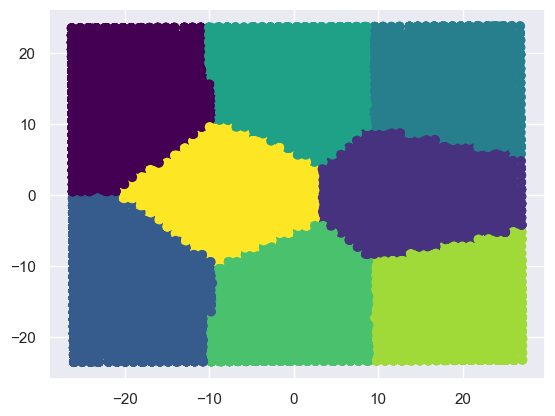

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans.labels_, cmap='viridis')